<b> EDA and feature engineering </b> notebook for <b>Project 2</b> of General Assembly DSIR-0320 <br>
by Martijn de Vries </br>
martijndevries91@gmail.com

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

Now that all the data is cleaned, it's time to get a sense of which variables would make sense to include in the model, and how we would encode them

In [70]:
df_train = pd.read_csv('../datasets/train_cleaned.csv', dtype={'MS SubClass':'object'})

In [71]:
#Let's start with countable features
for col in df_train.columns:
    if df_train[col].dtype != 'object':
        print(col)

Lot Frontage
Lot Area
Overall Qual
Overall Cond
Year Built
Year Remod/Add
Mas Vnr Area
BsmtFin SF 1
BsmtFin SF 2
Bsmt Unf SF
Total Bsmt SF
1st Flr SF
2nd Flr SF
Low Qual Fin SF
Gr Liv Area
Bsmt Full Bath
Bsmt Half Bath
Full Bath
Half Bath
Bedroom AbvGr
Kitchen AbvGr
TotRms AbvGrd
Fireplaces
Garage Yr Blt
Garage Cars
Garage Area
Wood Deck SF
Open Porch SF
Enclosed Porch
3Ssn Porch
Screen Porch
Pool Area
Misc Val
Mo Sold
Yr Sold
SalePrice


Now let's use a heatmap to see how these features correlate with sale price

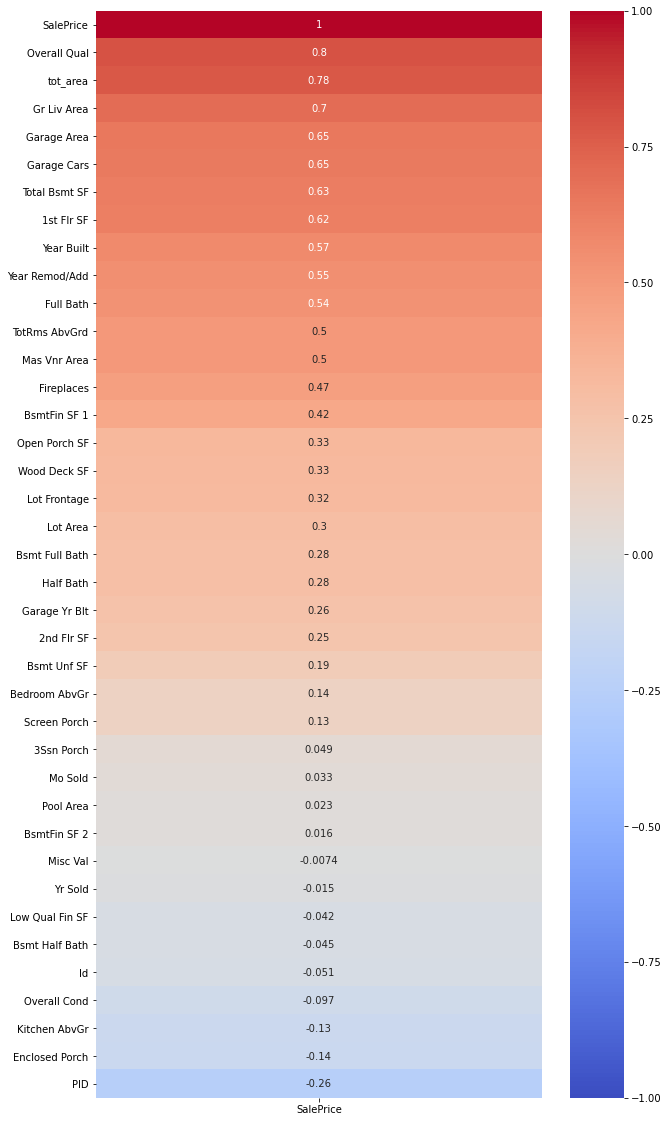

In [51]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(df_train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), cmap='coolwarm', vmin=-1, vmax=1, annot=True);

It seems there are a few numerical features that strongly correlate with sale price, great.

It occurs to me that some of these features could probably be combined to make the model more simple. Let's start with living area - maybe we should just make a new parameter 'tot_area' that sums 'Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', and '2nd Flr SF'

First, let's see how well these features are correlated (ie does it make sense to combine them?)

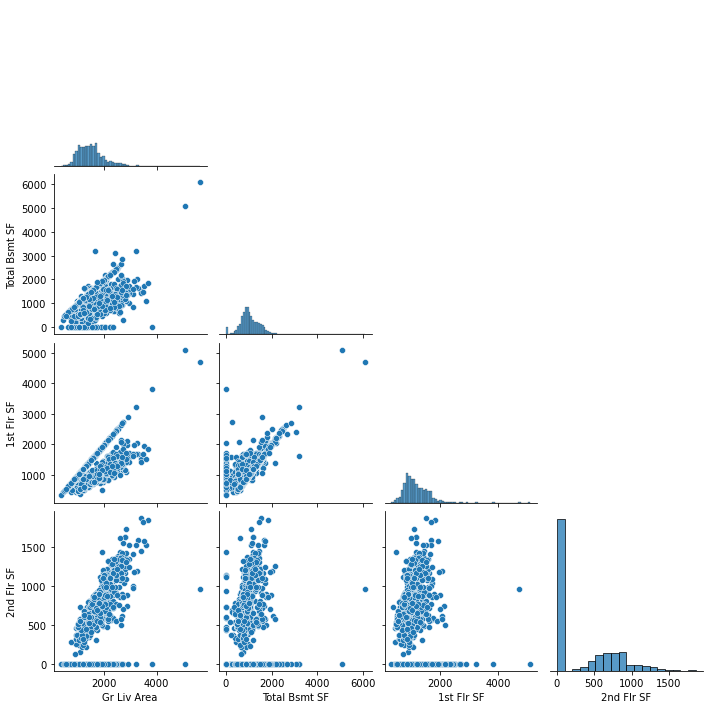

In [72]:
area_features = ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF']
sns.pairplot(df_train[area_features], corner=True);

Yup, they are clearly correlated

In [52]:

df_train['adj_tot_area'] = df_train['Gr Liv Area'] + \
            df_train['Total Bsmt SF']*0.3 + df_train['1st Flr SF']*0.5 + df_train['2nd Flr SF']*0.5 

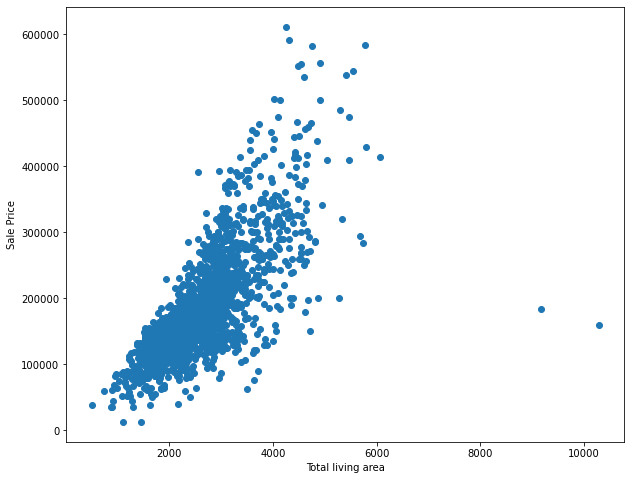

In [54]:
#how does this new variable correlatewth sale price?
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(df_train['adj_tot_area'], df_train['SalePrice'])
ax.set_xlabel('Total living area')
ax.set_ylabel('Sale Price')
plt.show()

Decent, although those outliers on the right are disturbing. What are those?

In [68]:
cols = ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'tot_area', 'Overall Qual', 'SalePrice', 'Sale Cond']
df_train[df_train['tot_area'] > 8500][cols]

KeyError: "['Sale Cond'] not in index"

Annoying, but with what I'm seeing here I'm not sure I can justify ignoring these outliers. For House 1885, it is suspicious though that the Ground floor, basement and 1st floor all have the exact same square footage. This might be a data entry error.

In [49]:
df_train.loc[1885:1885]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,tot_area
1885,2181,908154195,020,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,0,NaN,NaN,Elev,17000,10,2007,New,183850,15285.0
